In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [9]:
import numpy as np
import plotly.graph_objects as go
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

In [3]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range

# Load analytic

In [5]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
analytic_name = 'precision'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if analytic_name in f][0])
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']

In [6]:
param_range = create_parameter_range(config['parameter_based_simulation'])

x = np.load(fn)

# Species settings

In [7]:
n_species = x.shape[0]
choice11 = 'RNA_0'
choice12 = 'RNA_0'
choice21 = 'RNA_0'
choice22 = 'RNA_1'
slider1 = 'RNA_0'
slider2 = 'RNA_2'

output = 'RNA_1'

species_names = [f'RNA_{i}' for i in range(n_species)]

output_idx = species_names.index(output)
sig_idx = 0
paired_idxs = np.concatenate([np.triu_indices(3)[0][:, None], np.triu_indices(3)[1][:, None]], axis=1)
paired_idxs = [tuple(p) for p in paired_idxs]
choice1_idx = paired_idxs.index((species_names.index(choice11), species_names.index(choice12)))
choice2_idx = paired_idxs.index((species_names.index(choice21), species_names.index(choice22)))
static = 2
slider_idx = paired_idxs.index((species_names.index(slider1), species_names.index(slider2)))


# Simple 3D vis

In [47]:


slices = [static] * (len(x.shape) - 1)
slices[choice1_idx] = slice(x.shape[choice1_idx+1])
slices[choice2_idx] = slice(x.shape[choice2_idx+1])
z_data = x[tuple([output_idx] + slices)]


fig = go.Figure(data=[go.Surface(z=z_data)])

fig.update_layout(title=prettify_keys_for_label(analytic_name),
                  autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))
# fig.update_xaxes(labelalias=<VALUE>)
# fig.show()

# Stacked

In [48]:
slices = [slice(x.shape[1]), slice(x.shape[2]), 0, 0, 0, 0]
xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])

surfs = []
pi = 0
for si in range(n_species):
    if si == sig_idx:
        continue
    surfs.append(go.Surface(z=x[tuple([si] + slices)] +
                 xmax * pi, showscale=False, opacity=0.9))
    pi += 1
    # surfs.append(go.Surface(z=x[si, :, :, 0, 0, 0, 0] + si * xmax, showscale=False, opacity=0.9))

fig = go.Figure(data=surfs)

fig.update_layout(title=prettify_keys_for_label(analytic_name), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))

fig.write_html(f'stacked_{analytic_name}_{choice11}-{choice12}.html')

# Slider

In [49]:

fig = go.Figure()

for i, step in enumerate(param_range):
    
    slices = [static] * (len(x.shape) - 1)
    slices[choice1_idx] = slice(x.shape[choice1_idx+1])
    slices[choice2_idx] = slice(x.shape[choice2_idx+1])
    slices[slider_idx] = i

    xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])
    pi = 0
    for si in range(n_species):
        if si == sig_idx:
            continue
        fig.add_trace(
            go.Surface(z=x[tuple([si] + slices)] + xmax * pi,
                       visible=False,
                       name="[3] = " + f'{step:.2e}',
                       showscale=False, opacity=1.0),
        )
        pi += 1
        break

fig.data[0].visible = True

steps = []
for i, pr in zip(range(len(fig.data)), param_range):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + f'{pr:.2e}'}],  # layout attribute
        label=f'{pr:.02}'
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": f"Interaction strength {slider1}-{slider2}: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title=prettify_keys_for_label(analytic_name) + f' for {output}',
    scene=dict(
        xaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice11}-{choice12}"
        ),
        yaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice21}-{choice22}"
        ),
        zaxis=dict(title=prettify_keys_for_label(analytic_name) + ' ' + output)
    )
)

fig.write_html(f'slider_{analytic_name}_{choice11}-{choice12}.html')

## Slider show

In [50]:
fig.show()

# Adaptability

In [15]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'sensitivity' in f][0])
s = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'precision' in f][0])
p = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'overshoot' in f][0])
o = np.load(fn)

config = load_json_as_dict(os.path.join(sdir, 'experiment.json'))['config_params']
param_range = create_parameter_range(config['parameter_based_simulation'])


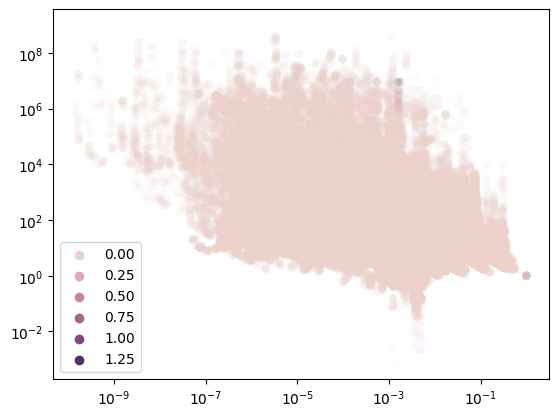

In [17]:
sns.scatterplot(x=s.flatten(), y=p.flatten(), hue=o.flatten(), alpha=0.05)
plt.xscale('log')
plt.yscale('log')